In [2]:
import csv
import numpy as np
from tkinter import *
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

### 1 Read data

In [23]:
# Use pandas to read the csv file, and name each column as , pariticipant, trial, x_left, x_right, y_left, y_right, attribute1, attribute 2, attribute 3
import pandas as pd
df = pd.read_csv('Q1 - Eye_data.csv', names=['participant', 'trial', 'x_left', 'x_right', 'y_left', 'y_right', 'attribute1', 'attribute2', 'attribute3'])
print(df)

         participant  trial  x_left  x_right  y_left  y_right  attribute1  \
0                  1      1   931.2  1002.40  608.80   615.70           1   
1                  1      1   932.0  1002.60  608.70   615.50           1   
2                  1      1   933.1  1002.30  608.10   615.30           1   
3                  1      1   933.7  1002.10  607.00   615.20           1   
4                  1      1   934.2  1001.90  606.40   615.30           1   
...              ...    ...     ...      ...     ...      ...         ...   
8405729           24     30   972.9   990.20  532.00   512.30         117   
8405730           24     30   972.7   990.33  532.43   512.12         117   
8405731           24     30   972.5   990.45  532.85   511.95         117   
8405732           24     30   972.3   990.58  533.28   511.78         117   
8405733           24     30   972.1   990.70  533.70   511.60         117   

         attribute2  attribute3  
0                 1        1596  
1      

In [24]:
df['x_left'] = (df['x_left'] + df['x_right'])/2
df['y_left'] = (df['y_left'] + df['y_right'])/2

In [25]:
# access all rows with participant number 1 and trial number 3    
pt = df[(df['participant']==3) & (df['trial']==16)].to_numpy()

In [ ]:
# For interpolate, it did not work well
for i in range(len(pt)):
    if np.isnan(pt[i][2]):
        for j in range(i, len(pt)):
            if not np.isnan(pt[j][2]):
                print(i, j)
                for m in range(i,0,-1):
                    if velocity[m]<2.5:
                        print("m",m)
                        break
                for n in range(j,len(pt)):
                    if velocity[n]<2.5:
                        print("n",n)
                        break
                # for k in range(i,j):
                #     pt[k,2] = pt[m,2] + (pt[n,2]-pt[m,2])/(n-m+1)*(k-m+1)
                break
        break

### 2. Plot velocity for each participant each trial

In [9]:
def draw_velocity(ptt):
    velocity = np.zeros(len(ptt)-1)
    for i in np.arange(len(ptt)-1):
        velocity[i] = np.sqrt((ptt[i+1,2] - ptt[i,2])**2 + (ptt[i+1,4] - ptt[i,4])**2)
    velocity = np.nan_to_num(velocity, nan=0)
    velocity = savgol_filter(velocity, 100, 5)
    # plot the velocity for by time, which is the row index of the data
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, 5.8, len(ptt)-1),velocity, marker='o', linestyle='-',markersize = 0.5)
    return velocity

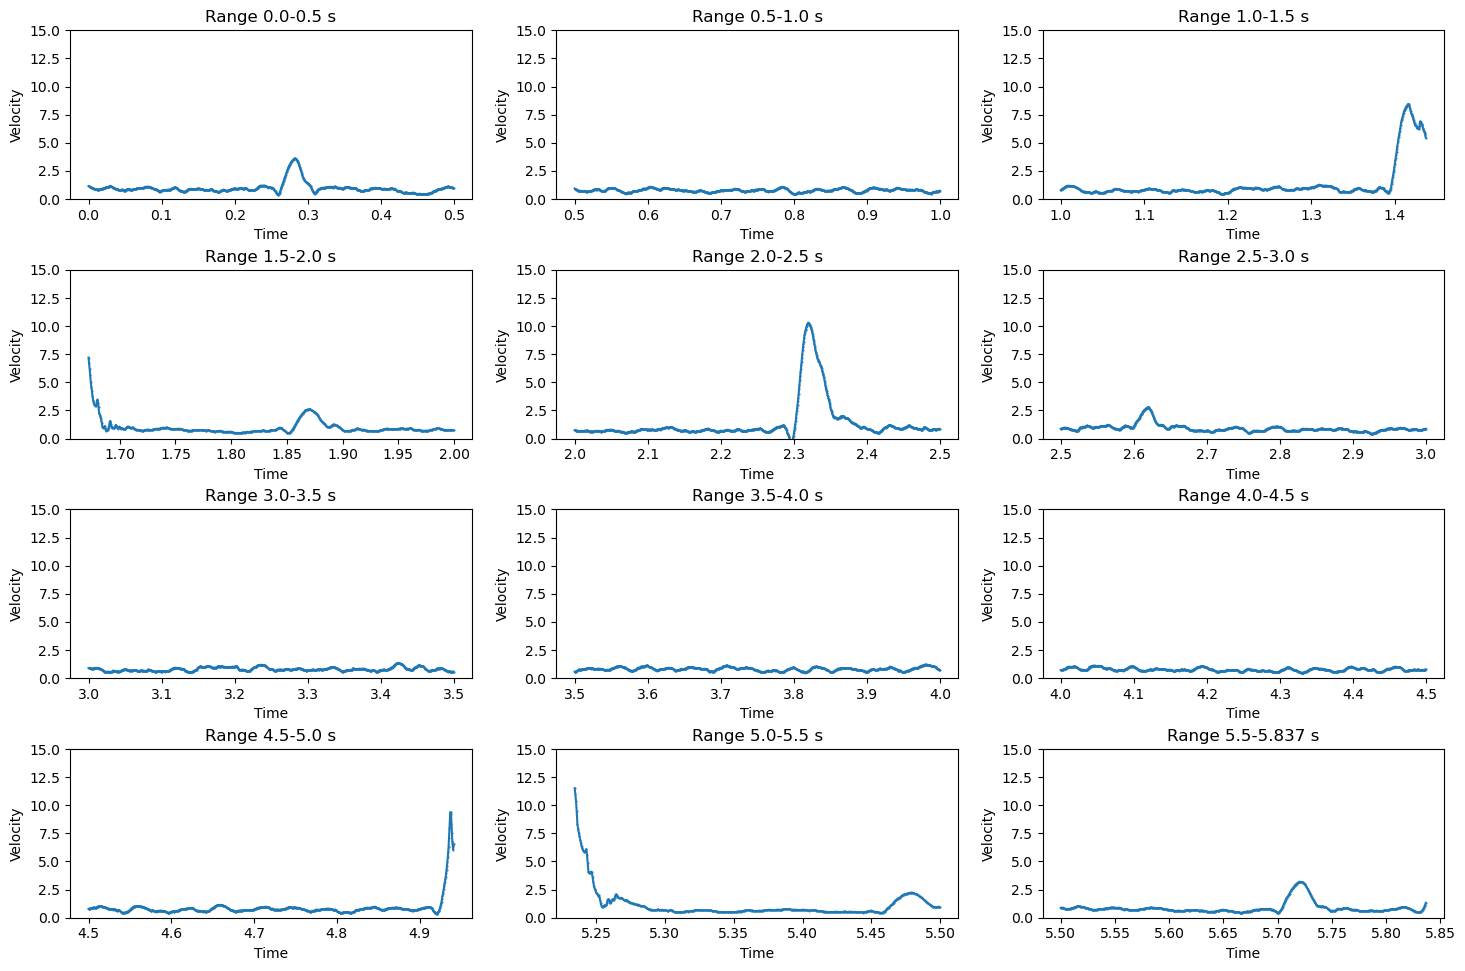

In [20]:
# Plot velocity by periods
ptt = pt.to_numpy()
velocity = np.zeros(len(ptt)-1)
for i in np.arange(len(ptt)-1):
    velocity[i] = np.sqrt((ptt[i+1,2] - ptt[i,2])**2 + (ptt[i+1,4] - ptt[i,4])**2)

# Define the ranges for subplots
ranges = [(0, 1000), (1000, 2000),(2000, 3000),(3000, 4000),(4000, 5000),(5000, 6000),(6000, 7000), (7000, 8000), (8000, 9000),(9000, 10000),(10000, 11000), (11000,len(ptt)-1)]
velocity = savgol_filter(velocity, 100, 5)
# Create 11 subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.tight_layout(pad=3.0)

for i, (start, end) in enumerate(ranges):
    subplot_row = i // 3
    subplot_col = i % 3

    # Plot the velocity for the specified range
    axes[subplot_row, subplot_col].plot(
        np.arange(start, end) * 0.0005, velocity[start:end],
        marker='o', linestyle='-', markersize=0.5
    )

    # Set labels and title for each subplot
    axes[subplot_row, subplot_col].set_ylim([0,15])
    axes[subplot_row, subplot_col].set_xlabel('Time')
    axes[subplot_row, subplot_col].set_xlabel('Time')
    axes[subplot_row, subplot_col].set_ylabel('Velocity')
    axes[subplot_row, subplot_col].set_title(f'Range {start*0.0005}-{end*0.0005} s')

# Show the subplots
plt.show()

## 3. Find saccades

In [ ]:
def find_saccades_1(velocity,ptt):  # This function finds all peaks including the blinks and offmonitor glances
    peak_indexes, peak_values = find_peaks(velocity, distance = 100, height=5.0)
    # print("this is the time point for the peaks: ", peak_indexes/(len(ptt)/5.8))
    onset = []
    offset = []
    onset_time = []
    offset_time = []
    for i in range(len(peak_indexes)):
        index = peak_indexes[i]
        for j in range(index,0,-1):
            if velocity[j] < 2.0:
                onset.append(j)
                onset_time.append(j/(len(ptt)/5.8))
                break
            if j == 0:
                onset.append(j)
                onset_time.append(j/(len(ptt)/5.8))
        for k in range(index,len(ptt)-1):
            if velocity[k]< 2.0:
                offset.append(k)
                offset_time.append(k/(len(ptt)/5.8))
                break
            if k == len(ptt)-2:
                offset.append(k)
                offset_time.append(k/(len(ptt)/5.8))
        print ("Eye movement ",i, ": ", "{:.2f}".format(onset_time[i]), "-", "{:.2f}".format(offset_time[i]))
    return onset, offset, onset_time, offset_time

In [27]:
def find_saccades_2(onset,offset,ptt): # This function removes the blinks and offmonitor glances
    onsets= []
    offsets = []
    onsets_time = []
    offsets_time = []
    for i in range(len(onset)):
        x = ptt[onset[i]:offset[i],2]
        y = ptt[onset[i]:offset[i],4]
        if not (np.any(np.isnan(x)) or np.any(np.isnan(y))):
            # print("i is okay",  i, "so onset is appended: ", onset[i]/(len(ptt)/5.8), offset[i]/(len(ptt)/5.8))
            onsets.append([onset[i]])
            offsets.append([offset[i]])
            onsets_time.append(onset[i]/(len(ptt)/5.8))
            offsets_time.append(offset[i]/(len(ptt)/5.8))
    # for j in range(len(onsets)):
    #     print ("Eye movement ",j, ": ", "{:.2f}".format(onsets_time[j]), "-", "{:.2f}".format(offsets_time[j]))
    return onsets, offsets, onsets_time, offsets_time

Watch each eye track trial as a video

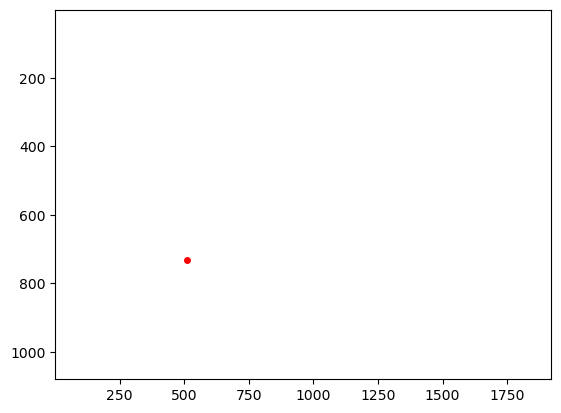

In [35]:
object = pt.copy()

# Create a Tkinter window
root = Tk()
root.title("Marker Drawer")

# Create a Frame to hold the matplotlib plot
frame = Frame(root)
frame.pack()

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

ax.set_xlim([1, 1920])
ax.set_ylim([1080, 1])

x0, y0 = object[0,2], object[0,4]
ax.plot(x0, y0, marker='o', color='red', markersize=4)

# Function to update the marker position based on the slider value
def update_marker(val):
    index = int(val)
    ax.clear()
    ax.set_xlim([1, 1920])
    ax.set_ylim([1080, 1])
    # Draw a marker on the canvas based on the x and y coordinates from the array
    x = object[index,2]
    y = object[index,4]
    ax.plot(x, y, marker='o', color='red', markersize=4)
    timeslot = object[index,6]*0.05
    x_,y_,timeslot_ = "{:.2f}".format(x),"{:.2f}".format(y),"{:.2f}".format(timeslot)
    value_label.config(text=f"Marker position: ({x_}, {y_}), video frame : {object[index,6]}, time {timeslot_}")
    fig.canvas.draw_idle()

# Create a slider
slider = Scale(root, from_=0, to=len(object) - 1, orient=HORIZONTAL, command=update_marker, length=300)
slider.pack()

# Create a label for additional information
value_label = Label(root, text="Marker position: (0, 0)")
value_label.pack()

# Show the initial plot
canvas = FigureCanvasTkAgg(fig, master=frame)
canvas.draw()
canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

# Run the Tkinter event loop
root.mainloop()
